# Text categorization with BERT

This notebook aim to test the [transformer](https://pypi.org/project/transformers/) python package developed by [huggingface](https://github.com/huggingface) which gives access to pretrained BERT models. In order to test this package and model we will use the dataset [Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) available on kaggle. I will personally run this notebook on a google colab in order to use the free GPUs, but you could run it on any other computer or VM.

#### Requierments:
- numpy==1.19.5
- pandas==1.1.5
- matplotlib==3.2.2
- torch==1.8.1+cu101
- transformers==4.5.1
- sklearn==0.0

### This cell need to be ran only if you are using google colab

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import os
os.chdir('drive/MyDrive/NLP/Disaster_tweets/src')
!pip install transformers

Mounted at /content/drive/


## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

from transformers import get_linear_schedule_with_warmup
from transformers import AdamW, BertConfig, BertModel, BertTokenizer

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

## Environement setup

We look if cuda is available and if so we indicate to PyTorch to run on the GPU instead of the CPU.

In [3]:
# select device
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

## Data loading

In [4]:
tweets = pd.read_csv("../data/disaster_tweets.csv").loc[:,["text","target"]]
tweets

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


### Check of the target balance

In [5]:
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Data preprocessing
We look for duplicates in the data and remove them.

In [6]:
dupli_sum = tweets.duplicated().sum()
if(dupli_sum > 0):
    print(dupli_sum, " duplicates found\nremoving...")
    tweets = tweets.loc[tweets.duplicated()==False, :]
else:
    print("no duplicates found")
tweets

92  duplicates found
removing...


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


### Seperate the features from the label

In [7]:
X_tweets = tweets["text"].values
y_tweets = tweets["target"].values

### Determination of the sequence length
As we will use batchs for the training we have to have all tweets of the same size. The tweets which are to long will be truncated, and the tweets too short will be padded. 

In [8]:
# We load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# We compute the length of each tweet in the dataset
lens = []
for text in X_tweets:
    encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    lens.append(encoded_dict['input_ids'].size()[1])

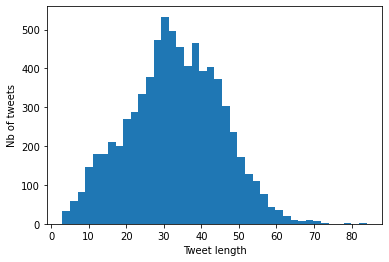

text length mean:  33.09626379470815
text length median:  33.0
text length standard deviation:  12.145367271204988
suitable sequence length:  57.38699833711813


In [9]:
plt.hist(lens, bins=40)
plt.xlabel('Tweet length')
plt.ylabel('Nb of tweets')
plt.show()

print("text length mean: ", np.array(lens).mean())
print("text length median: ", np.median(lens))
print("text length standard deviation: ", np.array(lens).std())
print("suitable sequence length: ", np.array(lens).mean() + 2*np.array(lens).std())

In [10]:
sequence_length = 58

## Tweets tockenization and tensor loading

Here we tockenize all the tweets with the BERT tockenizer and load them into PyTorch tensors. We also put all the tweets at the same size using padding and truncation based on the `sequence_length` computed earlier.

In [11]:
X_tweets_tokens = []

for text in X_tweets:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True, # special tokens for BERT
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt', # pytorch tensor format
                                         truncation=True)
    X_tweets_tokens.append(encoded_dict['input_ids'])

# pytorch expects tensors
X_tweets_tokens = torch.cat(X_tweets_tokens, dim=0) # concat into one tensor
y_tweets = torch.tensor(y_tweets)

#### An example of loaded tweet:

In [12]:
print('Original:\n', X_tweets[0])
print('Tokenization:\n', X_tweets_tokens[0])

Original:
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenization:
 tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])


### Split the dataset between train, validation and test

In [13]:
# split into training and validation data
dataset = TensorDataset(X_tweets_tokens, y_tweets.float())
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# We rebalance the train dataset
# unbalanced_X_train = np.array([ts[0].numpy() for ts in iter(train_set)])
# unbalanced_y_train = np.array([ts[1].numpy() for ts in iter(train_set)])
# train_pos_index = unbalanced_y_train > 0.5
# train_neg_index = unbalanced_y_train < 0.5
# train_pos_X, train_pos_y = unbalanced_X_train[train_pos_index], unbalanced_y_train[train_pos_index]
# train_neg_X, train_neg_y = unbalanced_X_train[train_neg_index], unbalanced_y_train[train_neg_index]
# nb_each_label_value = min(len(train_pos_y), len(train_pos_y))
# X_train = np.concatenate([train_pos_X[:nb_each_label_value], train_neg_X[:nb_each_label_value]])
# y_train = np.concatenate([train_pos_y[:nb_each_label_value], train_neg_y[:nb_each_label_value]])
# train_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).float())

print("Size of train set : ", len(train_set))
print("Size of val set : ", len(val_set))
print("Size of test set : ", len(test_set))

Size of train set :  5264
Size of val set :  1128
Size of test set :  1129


#### Check if the train set is balanced

In [14]:
balanced_y_train = np.array([ts[1].numpy() for ts in iter(train_set)])
balanced_y_train.mean()

0.42724165

#### *Observation:*
The dataset is not perfectly balanced but when we tried to fix this, it made more balanced predictions but the performance were overall slightly worst.

### Build the PyTorch data loaders

In [15]:
batch_size = 32

train_dataloader = DataLoader(train_set, 
                              sampler=RandomSampler(train_set), 
                              batch_size=batch_size)

validation_dataloader = DataLoader(val_set, 
                                   sampler=RandomSampler(val_set), 
                                   batch_size=batch_size)

test_dataloader = DataLoader(test_set, 
                             sampler=RandomSampler(test_set), 
                             batch_size=batch_size)

## Buidling the model based on BERT

Here we will build our model which is based on BERT (Bidirectional Encoder Representations from Transformers). BERT is basically a trained Transformer Encoder stack.

<img src="./bert-architecture.png" alt="drawing" width="400"/>

The embeding in front of the special token \[CLS\] will provide a representation of the whole tweet, will the other embedings represent each token of the tweet. We will use the embeded tweet provided by bert as an input to a shallow neural network which will be placed at the end on the neural network.

<img src="./bert-classifier.png" alt="drawing" width="400"/>

### Loading BERT model

We download the pretrained model bert and load it in the device. We will take this oportunity to look at the size of the BERT outputs

In [16]:
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device)

for batch in train_dataloader: 
    batch_features = batch[0].to(device)
    bert_output = bert(input_ids=batch_features) 
    print("bert output: ", type(bert_output), len(bert_output))
    print("first entry: ", type(bert_output[0]), bert_output[0].size())
    print("second entry: ", type(bert_output[1]), bert_output[1].size())
    break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert output:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 2
first entry:  <class 'torch.Tensor'> torch.Size([32, 58, 768])
second entry:  <class 'torch.Tensor'> torch.Size([32, 768])


### building class of the BERT classifier

As explained earlier, we simply add a linear and a sigmoid layer at the end of our model.

In [17]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased') # returns pwerful representations of the microblogs
        self.linear = nn.Linear(768, 1) # custom layer; input of the first custom layer has to match the dimensionality of the BERT-output; further custom layers are possible
        self.sigmoid = nn.Sigmoid() # activation function applied to our custom layer to obtain probabilities
    
    def forward(self, tokens):
        bert_output = self.bert(input_ids=tokens)
        linear_output = self.linear(bert_output[1])
        proba = self.sigmoid(linear_output)
        return proba

## Model training

We will train this model on 5 epochs on our 5200 tweets. We will evaluate the model on the validation set at the end of each epoch and save the best model based on the f1-score on the validation set.

### Eval and train function

In [18]:
def eval(y_batch, probas):
    preds_batch_np = np.round(probas.cpu().detach().numpy())
    y_batch_np = y_batch.cpu().detach().numpy()
    acc = accuracy_score(y_true=y_batch_np, y_pred=preds_batch_np)
    f1 = f1_score(y_true=y_batch_np, y_pred=preds_batch_np, average='weighted')
    return acc, f1

    

def train(model, optimizer, scheduler, epochs, name):
    history = []
    best_f1 = 0
    model.train()
    for epoch in range(epochs):
        
        # ===== train =====
        print("=== Epoch: ", epoch+1, " / ", epochs, " ===")
        acc_total = 0
        f1_total = 0
        for it, batch in enumerate(train_dataloader):
            if (it % 20) == 0:
                print(it)
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)] # draw the batch
            probas = torch.flatten(model(tokens=x_batch))
            acc_f1_batch = eval(y_batch, probas)
            acc_total, f1_total = acc_total + acc_f1_batch[0], f1_total + acc_f1_batch[1]
            model.zero_grad() # reset the gradients
            loss_func = nn.BCELoss()
            batch_loss = loss_func(probas, y_batch)
            batch_loss.backward() # calculate gradient per (learnable) weight
            optimizer.step() # update (learnable) weights
            scheduler.step() # update learning rate
        acc_total = acc_total/len(train_dataloader) #len(train dataloader)=num_batches
        f1_total = f1_total/len(train_dataloader)
        print("accuracy: ", acc_total, "\nf1: ", f1_total)

        # ===== validate =====
        acc_val_total = 0
        f1_val_total = 0
        for batch in validation_dataloader:
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
            with torch.no_grad(): # gradients don't have to be computed, because no update is performed
                probas = torch.flatten(model(tokens=x_batch))
            acc_f1_val_batch = eval(y_batch, probas)
            acc_val_total, f1_val_total = acc_val_total + acc_f1_val_batch[0], f1_val_total + acc_f1_val_batch[1]
        acc_val_total = acc_val_total/len(validation_dataloader)
        f1_val_total = f1_val_total/len(validation_dataloader)
        print("validation accuracy: ", acc_val_total, "\nvalidation f1: ", f1_val_total, "\n")
        if(f1_val_total>best_f1): # save current mdoel if this epoch improved models validation performance 
            torch.save(model, name+".pt")
            best_f1 = f1_val_total

        history.append({"epoch": epoch, "acc":acc_total, "f1":f1_total, "acc_val":acc_val_total, "f1_val":f1_val_total})
    return history

### Start training 

In [19]:
epochs = 5
# Build model
baseline_bert_clf = BertClassifier()
# load model in device
baseline_bert_clf = baseline_bert_clf.to(device)
# create optimizer
adam = AdamW(baseline_bert_clf.parameters(), lr=2e-5, eps=1e-8)
# Create scheduler
total_steps = len(train_dataloader) * epochs
sched = get_linear_schedule_with_warmup(adam, num_warmup_steps=0, num_training_steps=total_steps)
# Launch training
history = train(model=baseline_bert_clf, optimizer=adam, scheduler=sched, epochs=epochs, name="../models/baseline_bert_clf")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


=== Epoch:  1  /  5  ===
0
20
40
60
80
100
120
140
160
accuracy:  0.7893939393939394 
f1:  0.7817130800514509
validation accuracy:  0.8394097222222222 
validation f1:  0.8354012091477905 

=== Epoch:  2  /  5  ===
0
20
40
60
80
100
120
140
160
accuracy:  0.8710227272727272 
f1:  0.8693651528298577
validation accuracy:  0.8263888888888888 
validation f1:  0.826830747868641 

=== Epoch:  3  /  5  ===
0
20
40
60
80
100
120
140
160
accuracy:  0.9053030303030303 
f1:  0.9041178436894274
validation accuracy:  0.8472222222222222 
validation f1:  0.8449064061612177 

=== Epoch:  4  /  5  ===
0
20
40
60
80
100
120
140
160
accuracy:  0.9348484848484848 
f1:  0.9343778984944378
validation accuracy:  0.8263888888888888 
validation f1:  0.8253259207362528 

=== Epoch:  5  /  5  ===
0
20
40
60
80
100
120
140
160
accuracy:  0.9471590909090909 
f1:  0.946669828762785
validation accuracy:  0.8307291666666666 
validation f1:  0.8299339846123849 



### Visualisation of the training history

In [20]:
history_df = pd.DataFrame(history)
history_df

,epoch,acc,f1,acc_val,f1_val
0,0,0.789394,0.781713,0.839410,0.835401
1,1,0.871023,0.869365,0.826389,0.826831
2,2,0.905303,0.904118,0.847222,0.844906
3,3,0.934848,0.934378,0.826389,0.825326
4,4,0.947159,0.946670,0.830729,0.829934


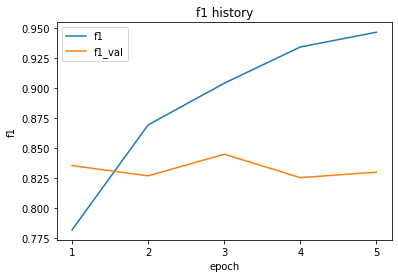

In [21]:
fig, ax = plt.subplots()
ax.set_title("f1 history")
ax.set_ylabel("f1")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0,20), labels=np.arange(1,21))
history_df.loc[:,['f1', 'f1_val']].plot(ax=ax)
plt.show()

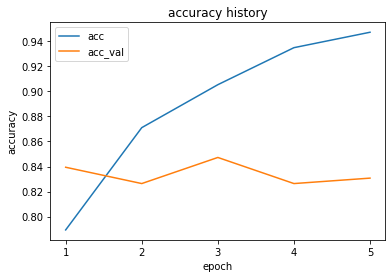

In [22]:
fig, ax = plt.subplots()
ax.set_title("accuracy history")
ax.set_ylabel("accuracy")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0,20), labels=np.arange(1,21))
history_df.loc[:,['acc', 'acc_val']].plot(ax=ax)
plt.show()

## Evaluate model
We load our best model on the validation set based on the f1-score, and evaluate it on the test set.

In [23]:
model = torch.load("../models/baseline_bert_clf.pt")

In [24]:
preds_np = np.array([])
y_np = np.array([])
acc_test_total = 0
f1_test_total = 0
for batch in test_dataloader:
    x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
    with torch.no_grad(): # gradients don't have to be computed, because no update is performed
        probas = torch.flatten(model(tokens=x_batch))
    preds_batch_np = np.round(probas.cpu().detach().numpy())
    preds_np = np.concatenate((preds_np, preds_batch_np))
    y_batch_np = y_batch.cpu().detach().numpy()
    y_np = np.concatenate((y_np, y_batch_np))
    acc_f1_test_batch = eval(y_batch, probas)
    acc_test_total, f1_test_total = acc_test_total + acc_f1_test_batch[0], f1_test_total + acc_f1_test_batch[1]
acc_test_total = acc_test_total/len(test_dataloader)
f1_test_total = f1_test_total/len(test_dataloader)
print("Test accuracy: ", acc_test_total, "\nTest f1: ", f1_test_total, "\n")

Test accuracy:  0.8270640432098766 
Test f1:  0.8254784028127033 



### Confusion matrix


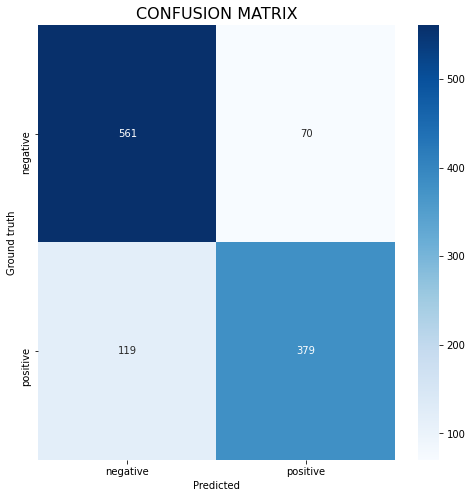

In [25]:
conf_mat = confusion_matrix(y_np, preds_np)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['negative', 'positive'], 
            yticklabels=['negative', 'positive'])
plt.ylabel('Ground truth')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX", size=16);

#### *Observation:*
The prediction errors from the model are not perfectly balanced but when we tried to fix it it overall made the performance slightly worst. However with an f1 score and an accuracy over 82%, the model is performing pretty well.